## First basic Visualization of the DBI environment


In [9]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd




ox.__version__

# turn response caching off
ox.settings.use_cache = True


## All available Streets and Buildings with entrances


In [10]:
# explore a neighborhood's buildings + street network interactively
cf = '["highway"~"service|footway|steps"]'
cols = ["wheelchair", "access"]
cols2 = ["name", "addr:unit", "description"]
place = "Gewerbepark Deutsches Brennstoffinstitut, Freiberg, Sachsen, Deutschland"

G = ox.graph.graph_from_place(place, network_type="all", retain_all=True, custom_filter=cf) 
gdf = ox.features.features_from_place(place, tags={"building": True})
gdf2 = ox.features.features_from_place(place, tags={'access': 'delivery', 'ref': 'poststation_dbi_09599'})
m = gdf.explore(tiles="cartodbdarkmatter",tooltip=cols2)
m = gdf2.explore(m=m,tooltip=cols,color= "red")

ox.convert.graph_to_gdfs(G, nodes=False).explore(m=m, color="yellow")


#save as html in Img folder in other directory
m.save("../Img/Gewerbepark Deutsches Brennstoffinstitut.html")

## Finding the shortest path to all Entrances

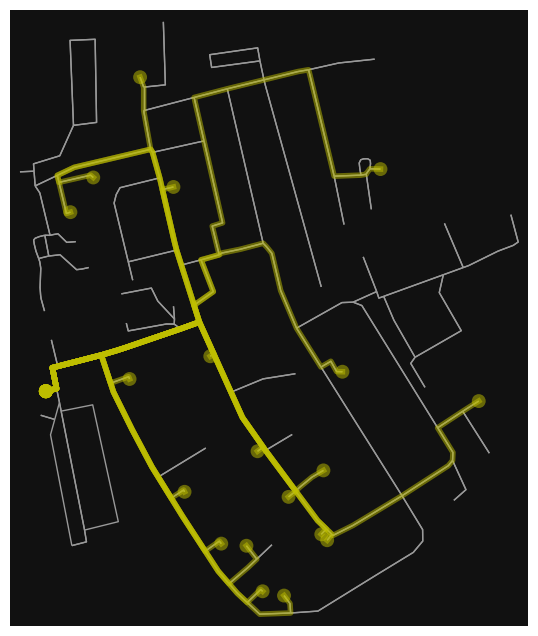

In [11]:

# Define origin node
origin = 3989756446

tags = {'access': 'delivery', 'wheelchair': 'yes', 'ref': 'poststation_dbi_09599'}

# Filter nodes to only those with the tag  'access': 'delivery' or 'ref': 'poststation_dbi_09599'
nodes_access = ox.features.features_from_place(place, tags=tags)

nodes = nodes_access[(nodes_access["access"] == "delivery")| (nodes_access["ref"] == "poststation_dbi_09599")]

if nodes.empty:
    raise ValueError("No entrance nodes found in the graph.")

# Convert entrance points to nearest graph nodes
nodes = [
    ox.nearest_nodes(G, x, y) for x, y in zip(nodes.geometry.x, nodes.geometry.y)
]

# Compute shortest paths to all entrance nodes
routes = []
for dest in nodes:
    try:
        route = nx.shortest_path(G, origin, dest, weight="length")
        routes.append(route)
    except nx.NetworkXNoPath:
        print(f"No path found to entrance node {dest}")

if not routes:
    raise ValueError("No valid routes found.")

# Plot the graph
fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0)

# Plot all routes
ox.plot_graph_routes(G, routes, route_colors="y", route_linewidth=2, node_size=0, ax=ax)

plt.show()


#save as png
fig.savefig("../Img/Routing_to_all_entrances.png")



## Routing to all accesible entrances

Total distance: 1701.9393416177559 meters


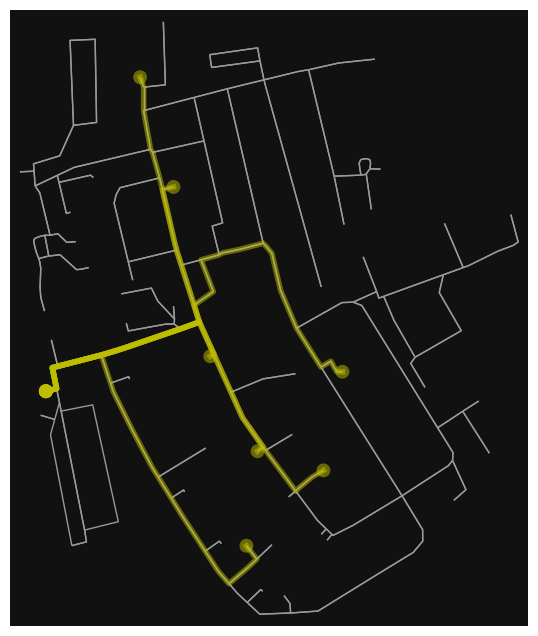

In [12]:

sum_distance = 0.0  # in meters

# Filter nodes to only those with the attribute 'entrance'
nodes_access = ox.features.features_from_place(place, tags=tags)
nodes = nodes_access[((nodes_access["access"] == "delivery") & (nodes_access["wheelchair"] == "yes"))| (nodes_access["ref"] == "poststation_dbi_09599")]



# Convert entrance points to nearest graph nodes
r_nodes = [
    ox.nearest_nodes(G, x, y) for x, y in zip(nodes.geometry.x, nodes.geometry.y)
]

# Compute shortest paths to all entrance nodes
routes = []
for dest in r_nodes:
    try:
        route = nx.shortest_path(G, origin, dest, weight="length")
        distance= nx.shortest_path_length(G, origin, dest, weight="length")
        sum_distance += distance
        
        routes.append(route)
    except nx.NetworkXNoPath:
        print(f"No path found to entrance node {dest}")

print(f"Total distance: {sum_distance} meters")

if not routes:
    raise ValueError("No valid routes found.")

# Plot the graph
fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0)

# Plot all routes
ox.plot_graph_routes(G, routes, route_colors="y", route_linewidth=2, node_size=0, ax=ax)

plt.show()

#save as png
fig.savefig("../Img/Routing_to_all_accesible_entrances.png")


Optimized TSP Path: [3989756446, 12545926734, 12545926742, 12545926745, 12545926744, 12545926730, 12545926741, 12545926731, 3989756446]


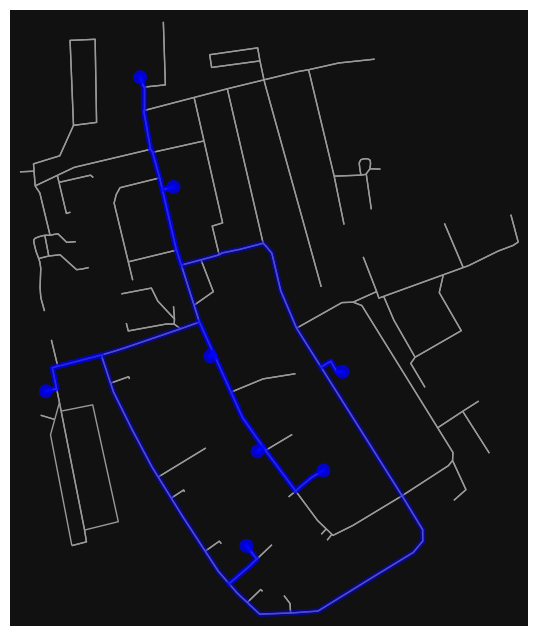

Total distance: 1483.14 meters


In [13]:

total_length = 0.0  # in meters
# Ensure we have valid nodes
if nodes is None or nodes.empty:
    raise ValueError("No destination nodes found. Check your 'nodes' filtering logic.")

# Filter only nodes present in G
all_nodes = nodes

all_nodes = [
    ox.nearest_nodes(G, x, y) for x, y in zip(all_nodes.geometry.x, all_nodes.geometry.y)
]

# Warn if some nodes are missing
#missing_nodes = [n for n in nodes if n not in G]
#if missing_nodes:
 #   print(f"Warning: Some nodes are missing from the graph: {missing_nodes}")

# Compute the shortest path distance matrix
distance_matrix = np.zeros((len(all_nodes), len(all_nodes)))

for i, node1 in enumerate(all_nodes):
    for j, node2 in enumerate(all_nodes):
        if i != j:
            try:
                distance_matrix[i, j] = nx.shortest_path_length(G, node1, node2, weight="length")
            except nx.NetworkXNoPath:
                print(f"No path between {node1} and {node2}. Setting distance to infinity.")
                distance_matrix[i, j] = np.inf  # No valid path

# Create a subgraph for TSP
subgraph = nx.Graph()
for i, node1 in enumerate(all_nodes):
    for j, node2 in enumerate(all_nodes):
        if i != j and distance_matrix[i, j] < np.inf:  # Ignore unreachable nodes
            subgraph.add_edge(node1, node2, weight=distance_matrix[i, j])

# Ensure we have enough nodes for TSP
if subgraph.number_of_nodes() < 2:
    raise ValueError("Not enough valid nodes to compute a TSP route.")

# Solve TSP (approximate)
tsp_path = nx.approximation.traveling_salesman_problem(subgraph, cycle=True)

# Print the optimized path
print("Optimized TSP Path:", tsp_path)

# Plot the graph
fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0)

# Convert TSP node sequence into a plotted route
tsp_routes = []
for i in range(len(tsp_path) - 1):  # Loop through pairs
    try:
        route = nx.shortest_path(G, tsp_path[i], tsp_path[i + 1], weight="length")
        tsp_routes.append(route)
        total_length += nx.shortest_path_length(G, tsp_path[i], tsp_path[i + 1], weight="length")
    except nx.NetworkXNoPath:
        print(f"No path found between {tsp_path[i]} and {tsp_path[i+1]}")

# Plot the optimized routes
ox.plot_graph_routes(G, tsp_routes, route_colors="b", route_linewidth=2, node_size=0, ax=ax)
print(f"Total distance: {total_length:.2f} meters")
plt.show()

#save as png
fig.savefig("../Img/Optimized_TSP.png")


## Distance to Origin

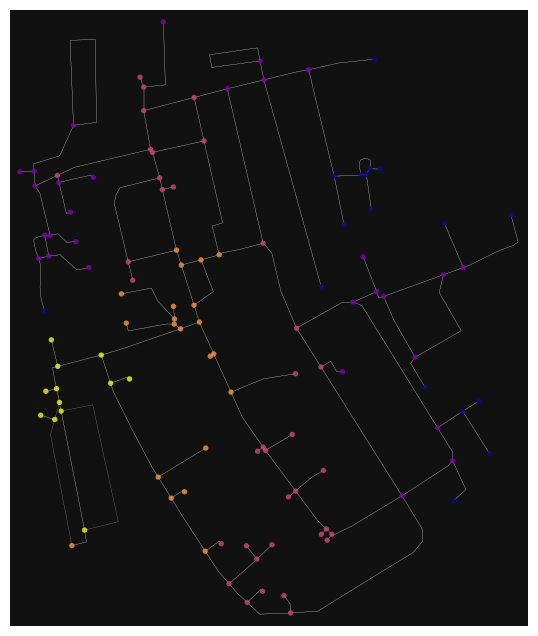

In [14]:


trip_times = [1,2,3,4,5]  # in minutes
travel_speed = 6  # driving speed in km/h



meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0)

# caclulate the shortest paths

# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, origin, radius=trip_time, distance="time")
 
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)




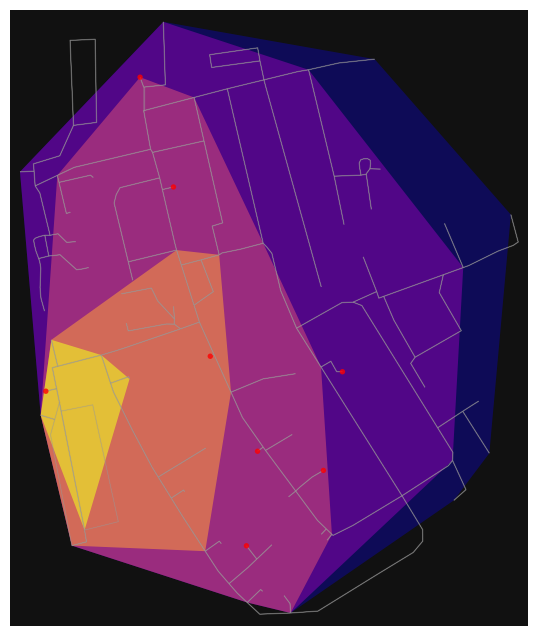

In [15]:
from shapely.geometry import Point

trip_times = [1,2,3,4,5]  # in minutes
travel_speed = 6  # driving speed in km/h



nodes_access = ox.features.features_from_place(place, tags=tags)
nodes = nodes_access[((nodes_access["access"] == "delivery") & (nodes_access["wheelchair"] == "yes"))| (nodes_access["ref"] == "poststation_dbi_09599")]

# make the isochrone polygons
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, origin, radius=trip_time, distance="time")
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).union_all().convex_hull
    isochrone_polys.append(bounding_poly)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys)


# add all entrance nodes
#place = "Gewerbepark Deutsches Brennstoffinstitut, Freiberg, Sachsen, Deutschland"
#tags = {'access': 'delivery', 'wheelchair': 'yes', 'ref': 'poststation_dbi_09599'}
# Filter nodes to only those with the attribute 'entrance'


# Plot the graph with isochrones and entrance nodes

fig, ax = ox.plot.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)

node_ids = [ox.nearest_nodes(G, x, y) for x, y in zip(nodes.geometry.x, nodes.geometry.y)]

# Plot entrance nodes
nc = ["red" if node in node_ids else "none" for node in G.nodes()]
ns = [15 if node in node_ids else 0 for node in G.nodes()]
ox.plot.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
    ax=ax,
)


plt.show()

#save as png
#fig.savefig("isochrones.png")